## Connect To Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')
root = "drive/MyDrive/CMP/"

Mounted at /content/drive


## Local

In [3]:
# root = './'

## Import Packages

In [4]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold
from tensorflow.keras.utils import plot_model
from sklearn import metrics

In [5]:
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

## Data Preparation

#### Load SUBTLEX data

In [6]:
# Loading subtlex data
SUBTLEX_df = pd.read_excel(root+'Datasets/SUBTLEX_Zipf.xlsx')

# renaming columns for latter merge use and dropping unneccery columns
SUBTLEX_df.rename(columns={'Word':'string', 'Zipf-value': 'zipf'}, inplace=True)
SUBTLEX_df.drop(SUBTLEX_df.columns[1:-1], axis=1, inplace=True)
SUBTLEX_df.head()

,string,zipf
0,a,7.309360
1,aa,3.236317
2,aaa,2.706807
3,aah,4.721425
4,aahed,1.592864


In [7]:
SUBTLEX_df['zipf'].describe()

count    74286.000000
mean         2.479172
std          0.835829
min          1.592864
25%          1.768955
50%          2.291834
75%          2.954592
max          7.621174
Name: zipf, dtype: float64

In [8]:
def categorise_by_zipf(row):
    """
    categorizing data string as High frequency word (HF),
    Low frequency word (LF) and non-word (NW) by zipf value

    Parameters
    ----------
        row: pandas series
            pandas dataframe's row containing label and zipf column
    
    Returns:
        category (str): HF, LF, NW
    """
    category = ''
    if row['label'] == 0:
        category = 'NW'
    elif row['label'] == 1 and row['zipf'] > 3:
        category = 'HF'
    else:
        category = 'LF'
    return category

#### Load ELP data and Merge with Subtlex data

Reading **words** and **non-words** FastText represention

In [9]:
with open(root+'Datasets/FastText_V3/words_2M.pkl', 'rb') as f:
  words = pickle.load(f)

with open(root+'Datasets/FastText_V3/nonwords_2M.pkl', 'rb') as f:
  nonwords = pickle.load(f)

Adding appropriate encodings for extra information for both words and non-words

In [10]:
for w in words:
    w.insert(3, [1, 0])
    w.insert(4, 1)

for nw in nonwords:
    nw.insert(1, 0)
    nw.insert(3, [0, 1])
    nw.insert(4, 0)

Loading elp data and merging them with subtlex data

In [11]:
# loading elp words and non-words as seprate dataframes
elp_words = pd.DataFrame(words, columns =['string', 'freq', 'represention', 'code', 'label'])
elp_nonwords = pd.DataFrame(nonwords, columns =['string', 'freq', 'represention', 'code', 'label'])

# mergeing elp words with subtlex words to get zipf for each elp words
# elp words that does not have zipf will be droped
elp_words = pd.merge(elp_words, SUBTLEX_df, on='string', how='left').dropna()
elp_df = pd.concat([elp_words, elp_nonwords])

# 
elp_df.fillna(0, inplace=True)
elp_df['category'] = elp_df.apply(lambda row: categorise_by_zipf(row), axis=1)
elp_df.drop_duplicates(subset=['string'], inplace=True)

In [12]:
elp_df = elp_df.sample(frac=1.0)
elp_df.head()

,string,freq,represention,code,label,zipf,category
34918,thashbuckler,0,"[-0.0008665227, 0.014849807, -0.0010132074, 0....","[0, 1]",0,0.0,NW
5882,citad,0,"[0.0058022263, -0.028454501, 0.10958578, 0.025...","[0, 1]",0,0.0,NW
28587,recipus,0,"[0.003661977, -0.052353755, 0.044805497, 0.002...","[0, 1]",0,0.0,NW
17969,imducted,0,"[0.014392407, -0.07275422, -0.0021653937, -0.0...","[0, 1]",0,0.0,NW
30756,suy,0,"[-0.12036725, -0.010891095, 0.009149347, -0.09...","[0, 1]",0,0.0,NW


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(elp_df['represention'],elp_df['code'], stratify=elp_df['label'], test_size=.2)

## Nueral Network

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense1 (Dense)              (None, 300)               90300     
                                                                 
 dense2 (Dense)              (None, 300)               90300     
                                                                 
 dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 dense3 (Dense)              (None, 100)               30100     
                                                                 
 dense4 (Dense)              (None, 50)                5050      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense5 (Dense)              (None, 10)               

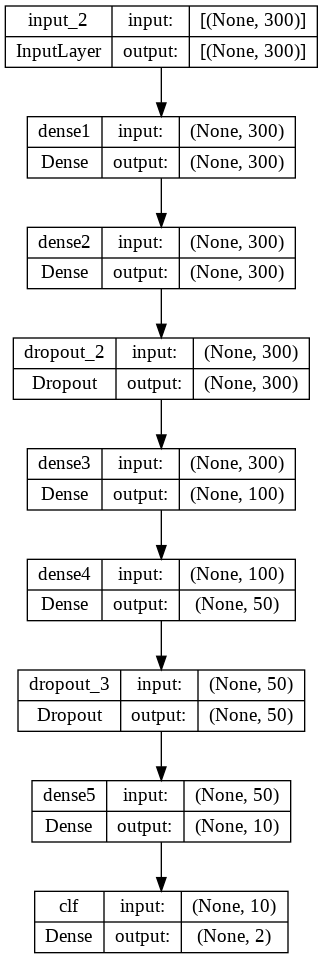

In [28]:
# Sequential Model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(300,)))
model.add(layers.Dense(300, activation="relu", name="dense1"))
model.add(layers.Dense(300, activation="relu", name="dense2"))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(100, activation="relu", name="dense3"))
model.add(layers.Dense(50, activation="relu", name="dense4"))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation="relu", name="dense5"))
model.add(layers.Dense(2, activation='softmax', name='clf'))

opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model.summary()
plot_model(model, to_file=root+'/Plots/Classification/fully_connected_model.png', show_shapes=True)

In [33]:
model.fit(
    x=np.array(list(X_train)),
    y=np.array(list(y_train)),
    validation_data=(np.array(list(X_test)), np.array(list(y_test))),
    epochs=10,
    callbacks=[
      tf.keras.callbacks.EarlyStopping(
          monitor='val_loss',
          patience=5,
          restore_best_weights=True
      )
  ]
)

Epoch 1/10
1858/1858 [==============================] - 13s 7ms/step - loss: 0.0454 - accuracy: 0.9861 - val_loss: 0.0312 - val_accuracy: 0.9905
Epoch 2/10
1858/1858 [==============================] - 15s 8ms/step - loss: 0.0222 - accuracy: 0.9936 - val_loss: 0.0284 - val_accuracy: 0.9920
Epoch 3/10
1858/1858 [==============================] - 13s 7ms/step - loss: 0.0160 - accuracy: 0.9955 - val_loss: 0.0276 - val_accuracy: 0.9922
Epoch 4/10
1858/1858 [==============================] - 13s 7ms/step - loss: 0.0108 - accuracy: 0.9969 - val_loss: 0.0337 - val_accuracy: 0.9924
Epoch 5/10
1858/1858 [==============================] - 13s 7ms/step - loss: 0.0083 - accuracy: 0.9978 - val_loss: 0.0380 - val_accuracy: 0.9932
Epoch 6/10
1858/1858 [==============================] - 14s 7ms/step - loss: 0.0068 - accuracy: 0.9984 - val_loss: 0.0620 - val_accuracy: 0.9919
Epoch 7/10
1858/1858 [==============================] - 14s 7ms/step - loss: 0.0065 - accuracy: 0.9984 - val_loss: 0.0553 - val_ac

In [34]:
model.save(root + '/check_points/fully_connected/FT_Model')

## Predicted Probabilities on full dataset


In [35]:
full_dataset_predictions = model.predict(np.array(list(elp_df['represention'])))

2323/2323 [==============================] - 6s 3ms/step


#### Classification results

In [36]:
print(metrics.classification_report(np.argmax(np.array(list(elp_df['code'])), axis=1), np.argmax(full_dataset_predictions, axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.9960    0.9965    0.9962     33978
           1     0.9971    0.9966    0.9968     40339

    accuracy                         0.9966     74317
   macro avg     0.9965    0.9966    0.9965     74317
weighted avg     0.9966    0.9966    0.9966     74317



In [37]:
acc_score = (metrics.accuracy_score(np.argmax(np.array(list(elp_df['code'])), axis=1),  np.argmax(full_dataset_predictions, axis=1)))
acc_score

0.9965687527752735

#### Confusion Matrix

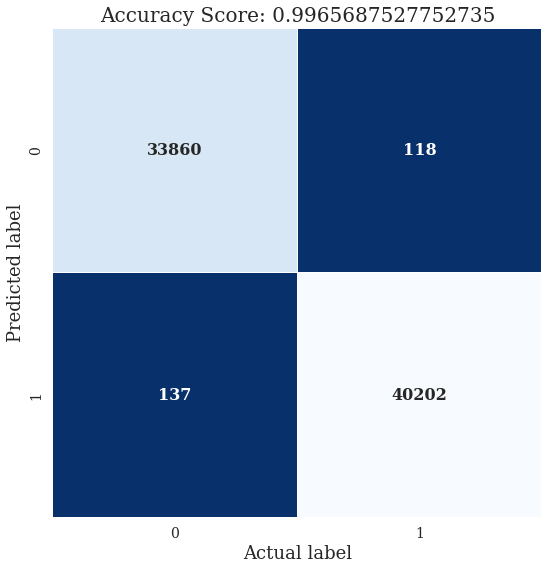

In [38]:
cm = metrics.confusion_matrix(np.argmax(np.array(list(elp_df['code'])), axis=1), np.argmax(full_dataset_predictions, axis=1))
plt.figure(figsize=(9,9))
hm = sns.heatmap(cm, annot=True, fmt=".0f", cbar=False, linewidths=.5, square = True, cmap = 'Blues_r',
            annot_kws={
                'fontsize': 16,
                'fontweight': 'bold'
            });
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 14)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 14)
hm.set_xlabel('Actual label', fontsize=18);
hm.set_ylabel('Predicted label', fontsize=18);
all_sample_title = 'Accuracy Score: {0}'.format(acc_score)
plt.title(all_sample_title, size = 20);
plt.savefig(root+'Plots/Classification/FC_full.pdf')

#### Pridected Probabilites for each words category and non-words

In [39]:
elp_df['word_prob'] = full_dataset_predictions[:,0]
elp_df['nword_prob'] = full_dataset_predictions[:,1]

In [40]:
elp_df.groupby(['category']).agg({'word_prob': ['mean', 'std', 'count', 'max', 'min'], 'nword_prob': ['mean', 'std', 'count', 'max', 'min']})

word_prob                                          nword_prob  \
              mean       std  count       max           min       mean   
category                                                                 
HF        0.994968  0.039728  14333  1.000000  1.149608e-03   0.005032   
LF        0.989212  0.065085  19645  1.000000  9.673266e-06   0.010788   
NW        0.005113  0.049588  40339  0.999996  6.607500e-17   0.994887   

                                                  
               std  count      max           min  
category                                          
HF        0.039728  14333  0.99885  4.349279e-35  
LF        0.065085  19645  0.99999  2.024046e-12  
NW        0.049588  40339  1.00000  4.136893e-06

## Save Predicted Probabilities of full dataset


In [41]:
elp_df_to_save = elp_df.drop(['represention', 'code'], axis=1)

In [42]:
elp_df_to_save

,string,freq,label,zipf,category,word_prob,nword_prob
34918,thashbuckler,0,0,0.000000,NW,2.327570e-03,0.997672
5882,citad,0,0,0.000000,NW,1.029650e-05,0.999990
28587,recipus,0,0,0.000000,NW,5.357853e-05,0.999946
17969,imducted,0,0,0.000000,NW,1.005859e-07,1.000000
30756,suy,0,0,0.000000,NW,9.614917e-06,0.999990
...,...,...,...,...,...,...,...
34118,stave,253,1,2.547107,LF,9.991799e-01,0.000820
6899,lonclusions,0,0,0.000000,NW,8.465163e-05,0.999915
27614,profing,0,0,0.000000,NW,1.867627e-03,0.998132
37271,utbeknownst,0,0,0.000000,NW,5.369962e-03,0.994630


In [43]:
elp_df_to_save.to_csv(root+"Datasets/fastText_FC.csv", header=0, index=False)